In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.sparse import diags
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.linalg import eigh
from sklearn.metrics.pairwise import euclidean_distances




# Tridiag 

In [2]:
# Tridiagonal hashing
X_train = np.load(r"C:\Users\Bruger\Desktop\vgg-16 data\wetransfer_features_2024-10-23_1202\features\train_features_vgg16_cifar10.npy")
y_train =np.load(r"C:\Users\Bruger\Desktop\vgg-16 data\wetransfer_features_2024-10-23_1202\features\train_labels_vgg16_cifar10.npy")
X_train = X_train[:5000]
y_train = y_train[:5000]

In [3]:
"""
train_features = np.load(r'c:\Users\Bruger\Desktop\p 7\Datasets\wetransfer_test_features_vgg16_cifar10-npy_2024-10-28_0903\train_features_vgg16_cifar10.npy')
val_features = np.load(r'c:\Users\Bruger\Desktop\p 7\Datasets\wetransfer_test_features_vgg16_cifar10-npy_2024-10-28_0903\val_features_vgg16_cifar10.npy')
test_features = np.load(r'c:\Users\Bruger\Desktop\p 7\Datasets\wetransfer_test_features_vgg16_cifar10-npy_2024-10-28_0903\test_features_vgg16_cifar10.npy')
train_labels= np.load(r"C:\Users\Bruger\Desktop\p 7\Datasets\wetransfer_test_features_vgg16_cifar10-npy_2024-10-28_0903\train_labels_vgg16_cifar10.npy")
val_labels = np.load(r"c:\Users\Bruger\Desktop\p 7\Datasets\wetransfer_test_features_vgg16_cifar10-npy_2024-10-28_0903\val_labels_vgg16_cifar10.npy")
test_labels = np.load(r"c:\Users\Bruger\Desktop\p 7\Datasets\wetransfer_test_features_vgg16_cifar10-npy_2024-10-28_0903\test_labels_vgg16_cifar10.npy")
"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 30-31: truncated \UXXXXXXXX escape (2226594232.py, line 1)

In [4]:

# : Standard Scaling
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)

# PCa
pca = PCA(n_components=256, random_state=42) 
data_pca = pca.fit_transform(X_train)

In [5]:
# Step 1: K-Means to find anchor points
n_anchors = 500
kmeans = KMeans(n_clusters=n_anchors, random_state=42)
kmeans.fit(data_pca)
anchors = kmeans.cluster_centers_


c:\Users\Bruger\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bruger\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Bruger\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


In [10]:
def spectral_hashing_rbf(data, anchors, hash_bits=16, gamma=1.0, k=10):
    # Step 1: Create the weight matrix W (data-to-anchor similarities) using RBF kernel
    W = 1 / (1 + euclidean_distances(data, anchors))  # Invert distance to create a similarity measure 
    # BRug RBF kernel til Weight matrix i stedet for, kunne ikke få det til at virke. 
    
    # Step 2: Sparsify W by keeping only the top-k similarities per row
    row_indices, col_indices, data_values = [], [], []
    for i in range(W.shape[0]):
        top_k_indices = np.argsort(W[i])[-k:]  # Select top-k highest similarities
        for j in top_k_indices:
            row_indices.append(i)
            col_indices.append(j)
            data_values.append(W[i, j])
    
    # Create sparse weight matrix W_sparse
    W_sparse = csr_matrix((data_values, (row_indices, col_indices)), shape=(data.shape[0], anchors.shape[0]))

    W_sym = W_sparse @ W_sparse.T  # Make it symmetric
    
    # Step 4: Compute the degree matrix D
    D = np.diag(np.array(W_sym.sum(axis=1)).flatten())
    
    # Step 5: Compute the Laplacian matrix L
    L = D - W_sym

    # Step 6: Compute the smallest non-zero eigenvectors for the Laplacian
    eigvals, eigvecs = eigh(L)
    eigvecs = eigvecs[:, 1:hash_bits+1]  # Exclude the first constant eigenvector, select next `hash_bits`
    
    # Step 7: Normalize using min-max scaling to [0, 1]
    eigvecs = (eigvecs - eigvecs.min(axis=0)) / (eigvecs.max(axis=0) - eigvecs.min(axis=0))
    
    # Step 8: Binarize using the median as the threshold
    medians = np.median(eigvecs, axis=0)
    hash_codes = (eigvecs > medians).astype(int)
    
    return hash_codes

# Example usage with gamma and k parameters
hash_codes = spectral_hashing_rbf(data_pca, anchors, hash_bits=16, gamma=1, k=50)
print("Generated Hash Codes:\n", hash_codes)


Generated Hash Codes:
 [[0 0 1 ... 1 1 1]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 1 ... 1 1 0]
 [0 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]]


In [11]:
def calculate_collisions(hash_codes):
    # Convert hash codes to strings for easy comparison
    hash_strings = [''.join(map(str, code)) for code in hash_codes]
    
    # Count occurrences of each unique hash code
    unique, counts = np.unique(hash_strings, return_counts=True)
    
    # Collisions occur when a code appears more than once
    collisions = sum(count - 1 for count in counts if count > 1)
    
    print(f"Total Collisions: {collisions}")
    print(f"Unique Hash Codes: {len(unique)} out of {len(hash_codes)}")
    return collisions

# Example usage
collisions = calculate_collisions(hash_codes) 

Total Collisions: 4776
Unique Hash Codes: 224 out of 5000


In [13]:
check_balanced_distribution(hash_codes)

Balanced Distribution Check: Passed
Bit-wise means (ideally close to 0.5): [0.5    0.5    0.4998 0.4998 0.5    0.5    0.5    0.4996 0.5    0.5
 0.5    0.5    0.5    0.5    0.5    0.5   ]


In [7]:
hash_codes.mean()

0.4999625

In [31]:
# Optionally: Keep only the top-k similarities for each data point
top_k = 20
W_sparse = np.zeros_like(W)
for i in range(W.shape[0]):
    top_k_indices = np.argsort(W[i])[-top_k:]  # Indices of top k similarities
    W_sparse[i, top_k_indices] = W[i, top_k_indices]

# Do not look (Tridiagonal hashing)

In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csr_matrix

def agh_tridiagonal_hashing(data, n_anchors=200, hash_bits=16, top_k=10, gamma=1.0):
    # Step 1: Anchor selection using k-means
    kmeans = KMeans(n_clusters=n_anchors, random_state=42)
    kmeans.fit(data)
    anchors = kmeans.cluster_centers_  # Get the anchor points

    # Step 2: Calculate the weight matrix W with RBF kernel
    #W = rbf_kernel(data, anchors, gamma=gamma)
    W =  1 / (1 + euclidean_distances(data, anchors))

    # Step 2.1: Normalize weights using softmax
    W_softmax = np.exp(W) / np.sum(np.exp(W), axis=1, keepdims=True)

    # Step 2.2: Keep the top k weights per row
    row_indices, col_indices, data_values = [], [], []
    for i in range(W_softmax.shape[0]):
        row = W_softmax[i]
        top_k_indices = np.argsort(row)[-top_k:]  # Get top k indices
        for j in top_k_indices:
            row_indices.append(i)
            col_indices.append(j)
            data_values.append(row[j])

    # Create sparse matrix W_sparse using csr_matrix for efficiency
    W_sparse = csr_matrix((data_values, (row_indices, col_indices)), shape=(data.shape[0], n_anchors))

    # Step 3: Compute the product W^T W for eigendecomposition
    W_product = W_sparse.T @ W_sparse  # W^T W

    # Step 4: Perform eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(W_product.toarray())

    # Step 5: Select smallest non-zero eigenvalues and corresponding eigenvectors
    non_zero_indices = np.where(eigvals > 0)[0]  # Find non-zero eigenvalues
    num_non_zero = len(non_zero_indices)

    # Ensure we do not exceed the available number of non-zero eigenvalues
    if num_non_zero < hash_bits:
        print(f"Warning: Only {num_non_zero} non-zero eigenvalues available. Reducing hash_bits to {num_non_zero}.")
        hash_bits = num_non_zero  # Adjust hash_bits if necessary

    smallest_indices = non_zero_indices[np.argsort(eigvals[non_zero_indices])[:hash_bits]]  # Get indices of smallest eigenvalues

    # Select corresponding eigenvectors
    smallest_eigvecs = eigvecs[:, smallest_indices]

    # Step 6: Project original data onto the smallest eigenvectors
    hash_codes = W_sparse @ smallest_eigvecs  # Correct projection

    # Step 7: Binarize the hash codes
    # Normalize before binarization
    hash_codes_normalized = hash_codes / np.linalg.norm(hash_codes, axis=1, keepdims=True)
    hash_codes_binary = (hash_codes_normalized > np.mean(hash_codes_normalized, axis=1, keepdims=True)).astype(int)

    return hash_codes_binary  # Output hash codes

# Example usage with your prepared data
# Assuming `data_pca` is your preprocessed data
hash_codes_train = agh_tridiagonal_hashing(data_pca, n_anchors= 500, hash_bits=32, top_k=50)
print("Hash Codes Shape:", hash_codes_train.shape)  # Should be (number of data points, hash_bits)
print("Hash Codes:\n", hash_codes_train)


c:\Users\Bruger\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Hash Codes Shape: (5000, 32)
Hash Codes:
 [[0 0 1 ... 0 1 0]
 [1 0 1 ... 1 1 0]
 [0 1 0 ... 1 1 0]
 ...
 [1 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 1]
 [1 0 0 ... 0 0 1]]


In [23]:
calculate_collisions(hash_codes_train)

Total Collisions: 2
Unique Hash Codes: 4998 out of 5000


2

# What is a good hash code

In [24]:
import numpy as np

def check_balanced_distribution(hash_codes):
    # Calculate the mean of each bit position across all hash codes
    bit_means = np.mean(hash_codes, axis=0)
    
    # Ideally, each bit mean should be close to 0.5
    balanced = np.allclose(bit_means, 0.5, atol=0.1)
    print("Balanced Distribution Check:", "Passed" if balanced else "Failed")
    print("Bit-wise means (ideally close to 0.5):", bit_means)
    
check_balanced_distribution(hash_codes_train)


Balanced Distribution Check: Passed
Bit-wise means (ideally close to 0.5): [0.5028 0.5084 0.4986 0.4954 0.5004 0.5096 0.4804 0.4846 0.4952 0.4932
 0.5064 0.481  0.4958 0.4986 0.4998 0.4944 0.5164 0.5046 0.492  0.4992
 0.483  0.5008 0.4984 0.5014 0.5132 0.4988 0.5034 0.5058 0.516  0.495
 0.4966 0.4978]


In [36]:
plot_codes = hash_codes[:-1,:12]

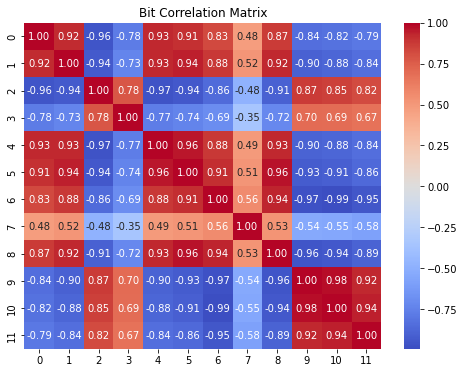

Uncorrelated Bits Check: Failed


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def check_uncorrelated_bits(hash_codes):
    # Calculate the correlation matrix of bits
    correlation_matrix = np.corrcoef(hash_codes.T)
    
    # Plot the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Bit Correlation Matrix")
    plt.show()

    # Check if correlations are close to 0 (excluding diagonal)
    uncorrelated = np.all(np.abs(correlation_matrix - np.eye(hash_codes.shape[1])) < 0.1)
    print("Uncorrelated Bits Check:", "Passed" if uncorrelated else "Failed")
    
check_uncorrelated_bits(plot_codes)


# Er det modellen eller dataet der er galt???

In [23]:
from sklearn.datasets import make_blobs

# Generate synthetic data with 4 clusters and high variance
synthetic_data, _ = make_blobs(n_samples=500, centers=4, n_features=100, random_state=42, cluster_std=5.0)

# Standardize and apply PCA
synthetic_data_scaled = scaler.fit_transform(synthetic_data)
synthetic_data_pca = pca.fit_transform(synthetic_data_scaled)

# Apply tridiagonal hashing on the synthetic data subset
hash_codes_synthetic = agh_tridiagonal_hashing(synthetic_data_pca, n_anchors=50, hash_bits=8)

# Check the balance of synthetic hash codes
check_balanced_distribution(hash_codes_synthetic)

c:\Users\Bruger\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bruger\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Balanced Distribution Check: Failed
Bit-wise means (ideally close to 0.5): [0.42 0.66 0.62 0.66 0.44 0.62 0.5  0.5 ]


In [9]:
from scipy.spatial.distance import pdist, squareform

def analyze_hamming_distances(hash_codes):
    # Calculate pairwise Hamming distances
    hamming_distances = pdist(hash_codes, metric='hamming')
    
    # Display the distribution of Hamming distances
    print("Hamming Distance Stats - Mean:", np.mean(hamming_distances),
          "Std Dev:", np.std(hamming_distances))
    plt.hist(hamming_distances, bins=20, edgecolor='black')
    plt.xlabel("Hamming Distance")
    plt.ylabel("Frequency")
    plt.title("Distribution of Pairwise Hamming Distances")
    plt.show()

# Run analysis on CIFAR hash codes
#analyze_hamming_distances(hash_codes_train)

In [20]:
train_subset.shape

(500, 4096)

c:\Users\Bruger\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


anchors found
rbf kernel computed
Balanced Distribution Check: Failed
Bit-wise means (ideally close to 0.5): [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
Hamming Distance Stats - Mean: 0.06666666666666665 Std Dev: 1.3877787807814457e-17


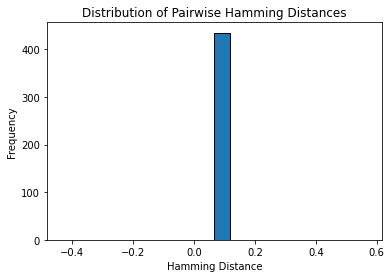

In [35]:
def agh_full_hashing(data, n_anchors=50, hash_bits=16, gamma=1.0):
    kmeans = KMeans(n_clusters=n_anchors, random_state=42).fit(data)
    anchors = kmeans.cluster_centers_
    print("anchors found")
    # Compute full RBF kernel similarities
    W_full = rbf_kernel(data, anchors, gamma=gamma)
    print("rbf kernel computed")
    # Eigen decomposition for full weight matrix
    W_product = W_full.T @ W_full  # Square matrix (n_anchors x n_anchors)
    eigvals, eigvecs = np.linalg.eigh(W_product)
    eigvecs = eigvecs[:, -hash_bits:]
    
    hash_codes = (eigvecs > 0).astype(int)
    
    return hash_codes

# Apply full hashing model to synthetic data
hash_codes_synthetic_full = agh_full_hashing(data_pca, n_anchors=30, hash_bits=32)
check_balanced_distribution(hash_codes_synthetic_full)
analyze_hamming_distances(hash_codes_synthetic_full)


Explained Variance by PCA Components: [0.1275262  0.18713187 0.24146613 ... 0.9999974  0.9999974  0.9999974 ]


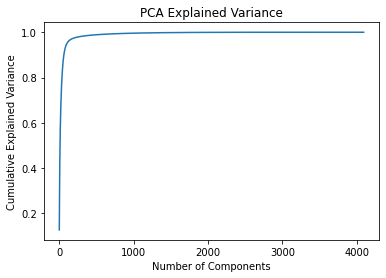

Estimated Intrinsic Dimensionality: 62.32114670418513


In [37]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1. PCA Explained Variance Analysis
pca = PCA().fit(train_subset)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print("Explained Variance by PCA Components:", explained_variance_ratio)

# Plot to see the elbow point
import matplotlib.pyplot as plt
plt.plot(explained_variance_ratio)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

# 2. MLE-based Intrinsic Dimensionality Estimation
def mle_intrinsic_dim(data, k=10):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    distances, _ = nbrs.kneighbors(data)
    distances = distances[:, 1:]  # exclude the point itself (distance 0)
    logs = np.log(distances[:, -1] / distances[:, 0])
    return (k - 2) / np.mean(logs)  # MLE formula for intrinsic dimension

estimated_dim = mle_intrinsic_dim(train_subset)
print("Estimated Intrinsic Dimensionality:", estimated_dim)


In [15]:
train_subset

array([[-1.5744238 , -1.3606493 , -3.286768  , ..., -1.3228954 ,
         0.39529726, -0.13792479],
       [ 0.90502304, -0.229833  , -1.0953906 , ..., -0.86987156,
        -2.5256033 , -2.501156  ],
       [-1.1630226 , -1.2027507 , -0.7959843 , ..., -1.309034  ,
        -2.4041934 ,  1.3667796 ],
       ...,
       [ 0.73317194,  0.09656927, -1.3344581 , ...,  0.21072027,
        -1.0600235 , -0.37726656],
       [-0.006379  , -0.48351598, -2.9165614 , ..., -1.3137317 ,
        -0.61530876, -0.9574325 ],
       [-0.48573282, -1.4502957 , -0.01148711, ...,  1.6664779 ,
         0.5078867 , -2.3402555 ]], dtype=float32)

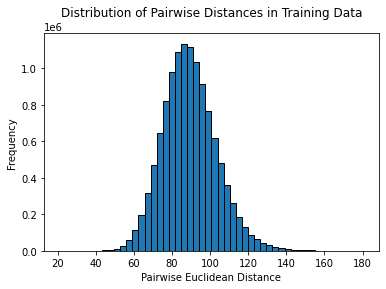

Mean Pairwise Distance: 89.21145130495215
Standard Deviation of Pairwise Distances: 14.066309730020363


In [38]:
from scipy.spatial.distance import pdist

# Calculate pairwise Euclidean distances
distances = pdist(train_subset, metric='euclidean')

# Plot the distribution of pairwise distances
plt.hist(distances, bins=50, edgecolor='black')
plt.xlabel("Pairwise Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances in Training Data")
plt.show()

# Calculate basic statistics
print("Mean Pairwise Distance:", np.mean(distances))
print("Standard Deviation of Pairwise Distances:", np.std(distances))


In [17]:
import numpy as np

In [18]:
X_train = np.load(r"C:\Users\Bruger\Desktop\vgg-16 data\wetransfer_features_2024-10-23_1202\features\train_features_vgg16_cifar10.npy")
y_train =np.load(r"C:\Users\Bruger\Desktop\vgg-16 data\wetransfer_features_2024-10-23_1202\features\train_labels_vgg16_cifar10.npy")
X_train = X_train[:5000]
y_train = y_train[:5000]

In [20]:

# Step 1: Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Step 2: PCA Transformation (retain 95% of variance)
pca = PCA(n_components=256, random_state=42)  # Adjust variance threshold if needed
X_train = pca.fit_transform(X_train)

pairwise calculated
calculating something
Intra-Class Distances - Mean: 79.38724255007428 Std Dev: 12.900524206428999
Inter-Class Distances - Mean: 89.48803862634159 Std Dev: 13.154040697435713


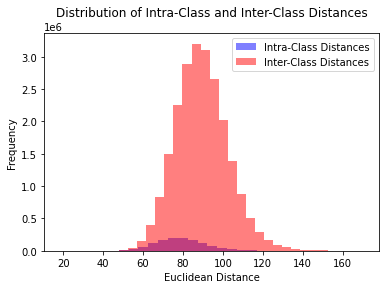

In [21]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Assume `train_subset` contains the data and `train_labels` contains corresponding labels
# Compute pairwise distances
pairwise_distances = squareform(pdist(X_train, metric='euclidean'))
print("pairwise calculated")
# Get unique labels
unique_labels = np.unique(y_train)

# Initialize lists to store intra-class and inter-class distances
intra_class_distances = []
inter_class_distances = []

# Calculate intra-class and inter-class distances
print("calculating something")
for i, label in enumerate(unique_labels):
    # Indices of data points with the current label
    same_class_indices = np.where(y_train == label)[0]
    diff_class_indices = np.where(y_train != label)[0]
    
    # Intra-class distances
    if len(same_class_indices) > 1:  # Only calculate if more than one instance per class
        intra_dists = pairwise_distances[np.ix_(same_class_indices, same_class_indices)]
        intra_class_distances.extend(intra_dists[np.triu_indices(len(same_class_indices), k=1)])

    # Inter-class distances
    inter_dists = pairwise_distances[np.ix_(same_class_indices, diff_class_indices)]
    inter_class_distances.extend(inter_dists.flatten())

# Calculate statistics
intra_class_mean = np.mean(intra_class_distances)
intra_class_std = np.std(intra_class_distances)
inter_class_mean = np.mean(inter_class_distances)
inter_class_std = np.std(inter_class_distances)

# Display results
print("Intra-Class Distances - Mean:", intra_class_mean, "Std Dev:", intra_class_std)
print("Inter-Class Distances - Mean:", inter_class_mean, "Std Dev:", inter_class_std)

# Plotting the distributions
import matplotlib.pyplot as plt

plt.hist(intra_class_distances, bins=30, alpha=0.5, label='Intra-Class Distances', color='blue')
plt.hist(inter_class_distances, bins=30, alpha=0.5, label='Inter-Class Distances', color='red')
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.title("Distribution of Intra-Class and Inter-Class Distances")
plt.show()


c:\Users\Bruger\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Bruger\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


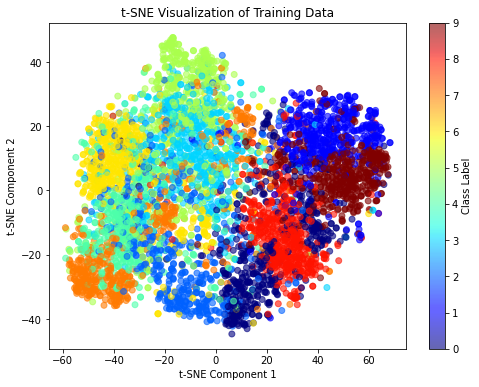

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
data_tsne = tsne.fit_transform(X_train)

# Plot t-SNE results, coloring by labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=y_train, cmap='jet', alpha=0.6)
plt.colorbar(scatter, label='Class Label')
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [49]:
X_train.shape

(5000, 4096)

In [48]:
train_subset.shape

(5000, 4096)

Intra-Class Distances - Mean: 79.47575834048682 Std Dev: 12.8955004729217
Inter-Class Distances - Mean: 90.26191779352563 Std Dev: 13.467396471887934


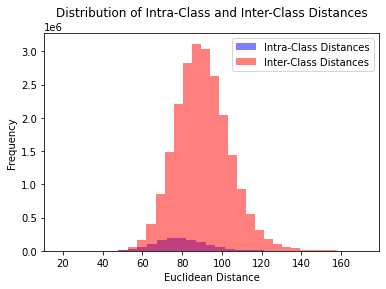

In [41]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

# Assume `train_subset` contains the data and `train_labels` contains corresponding labels
# Compute pairwise distances
pairwise_distances = squareform(pdist(train_subset, metric='euclidean'))

# Get unique labels
unique_labels = np.unique(train_labels)

# Initialize lists to store intra-class and inter-class distances
intra_class_distances = []
inter_class_distances = []

# Calculate intra-class and inter-class distances
for i, label in enumerate(unique_labels):
    # Indices of data points with the current label
    same_class_indices = np.where(train_labels == label)[0]
    diff_class_indices = np.where(train_labels != label)[0]
    
    # Intra-class distances
    if len(same_class_indices) > 1:  # Only calculate if more than one instance per class
        intra_dists = pairwise_distances[np.ix_(same_class_indices, same_class_indices)]
        intra_class_distances.extend(intra_dists[np.triu_indices(len(same_class_indices), k=1)])

    # Inter-class distances
    inter_dists = pairwise_distances[np.ix_(same_class_indices, diff_class_indices)]
    inter_class_distances.extend(inter_dists.flatten())

# Calculate statistics
intra_class_mean = np.mean(intra_class_distances)
intra_class_std = np.std(intra_class_distances)
inter_class_mean = np.mean(inter_class_distances)
inter_class_std = np.std(inter_class_distances)

# Display results
print("Intra-Class Distances - Mean:", intra_class_mean, "Std Dev:", intra_class_std)
print("Inter-Class Distances - Mean:", inter_class_mean, "Std Dev:", inter_class_std)

# Plotting the distributions
import matplotlib.pyplot as plt

plt.hist(intra_class_distances, bins=30, alpha=0.5, label='Intra-Class Distances', color='blue')
plt.hist(inter_class_distances, bins=30, alpha=0.5, label='Inter-Class Distances', color='red')
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.title("Distribution of Intra-Class and Inter-Class Distances")
plt.show()
